<a href="https://colab.research.google.com/github/justinwickelgren/data-science-class/blob/main/Unit_4_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

with pm.Model(coords=aa_coords) as studentT_model:
    μ_mu = pm.StudentT('μ_mu', nu = 5, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu = 5, sigma = 10)
    ν = pm.HalfStudentT('ν', nu = 5, sigma = 10)

    μ = pm.StudentT('μ',
                  nu = ν,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 5, sigma = 10,
                      dims = "aa")

    y = pm.StudentT('y',
                  nu = ν,
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    studentT_data = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as normal_model:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    normal_data = pm.sample()

Output()

Output()

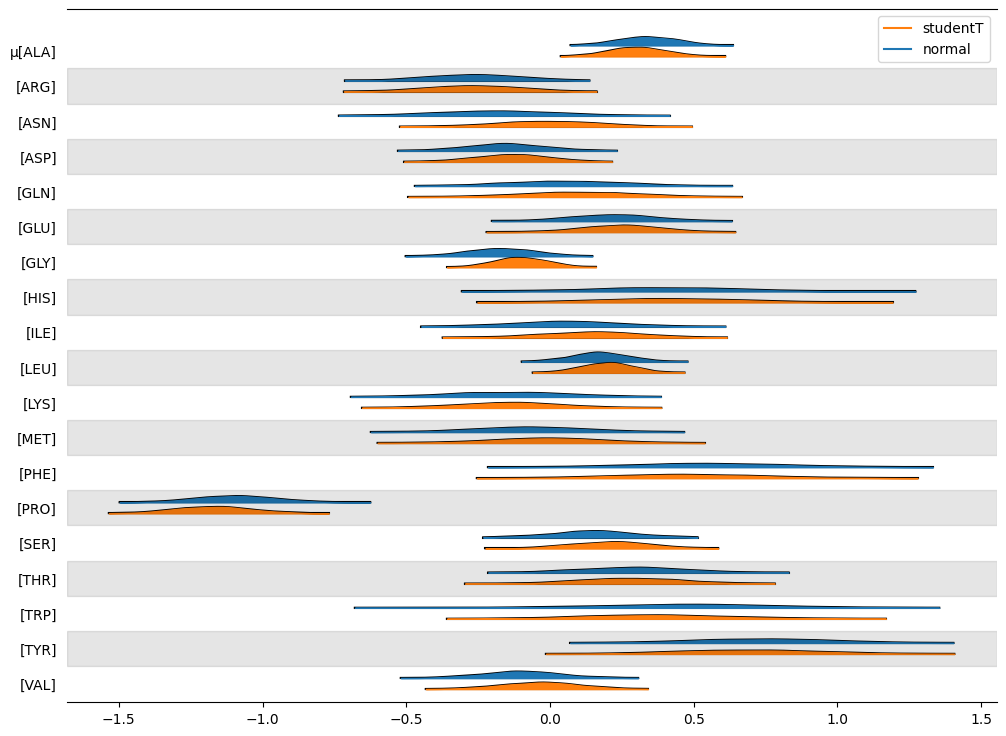

In [ ]:
axes = az.plot_forest([normal_data, studentT_data], model_names=["normal", "studentT"], kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

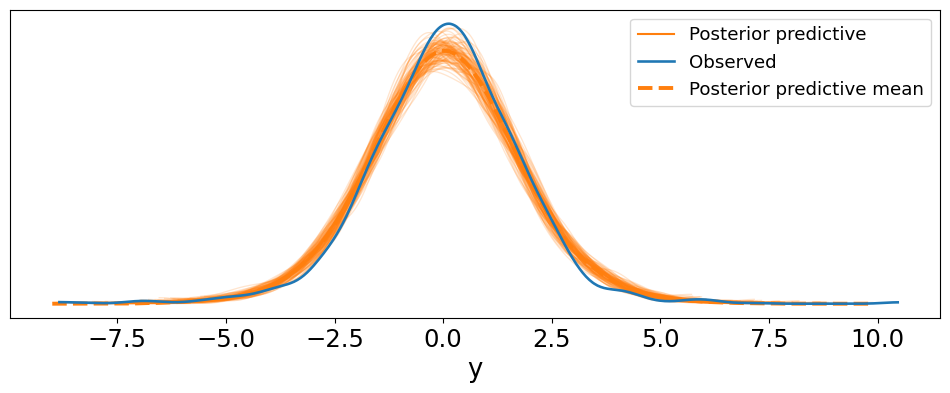

In [ ]:
pm.sample_posterior_predictive(normal_data, model=normal_model, extend_inferencedata=True)
az.plot_ppc(normal_data, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

<Axes: xlabel='y'>

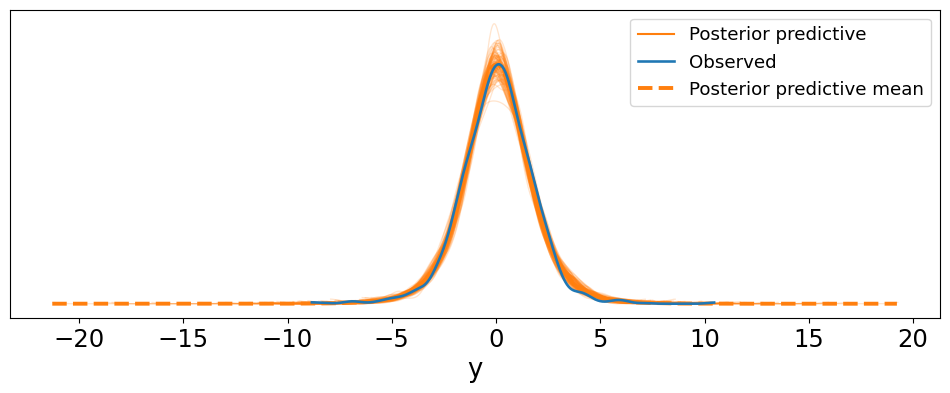

In [ ]:
pm.sample_posterior_predictive(studentT_data, model=studentT_model, extend_inferencedata=True)
az.plot_ppc(studentT_data, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The StudentT and HalfStudentT model fits the data better. It's peak is the same height as the data, while the Normal and HalfNormal model has a peak that is not as well aligned with the data. The tails of the StudentT model also appear to be a little closer to the data.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha=2, beta=20, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

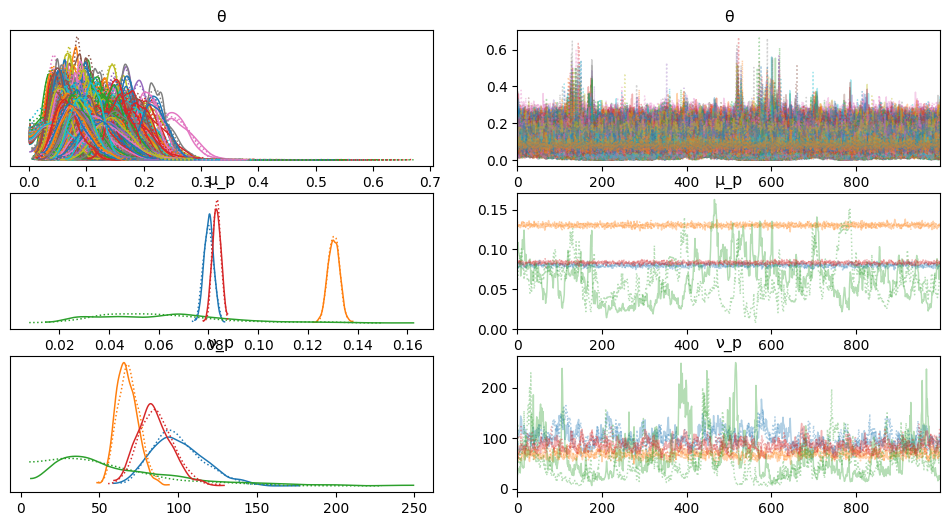

In [ ]:
az.plot_trace(idata_sccr)

In [ ]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.001 1.004 1.0 ... 1.002 1.005 1.001
    μ_p      (pos) float64 32B 1.002 0.9999 1.024 1.001
    ν_p      (pos) float64 32B 1.03 1.006 1.033 1.006

The plot trace is quite similar to the hierarchical model, but there are a few differences. The top right has more peaks in the middle and less on the left. There's also a peak at 0 on the bottom left that isn't there in the hierarchical model. The rhat values are similar to the hierarchical model, however, the rhat for goalkeeper is closer to 1, so the model is more confident about the goalkeeper shooting percentage than in the hierarchical model.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

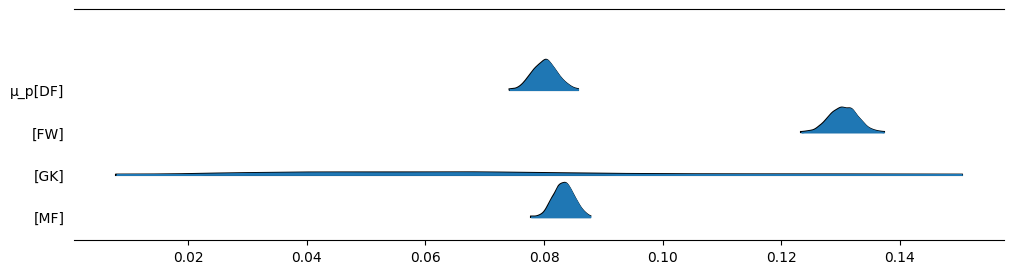

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These posteriors are narrowers than the hierarchical model we did in class. The model is more confident about the shooting percentage for all positions (except goalkeeper, which it knows essentially nothing about in either). All of the posteriors are centered at about the same value as they are for the hierarchical model.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data = sccr_data[sccr_data.position != 'GK']
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    h_idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

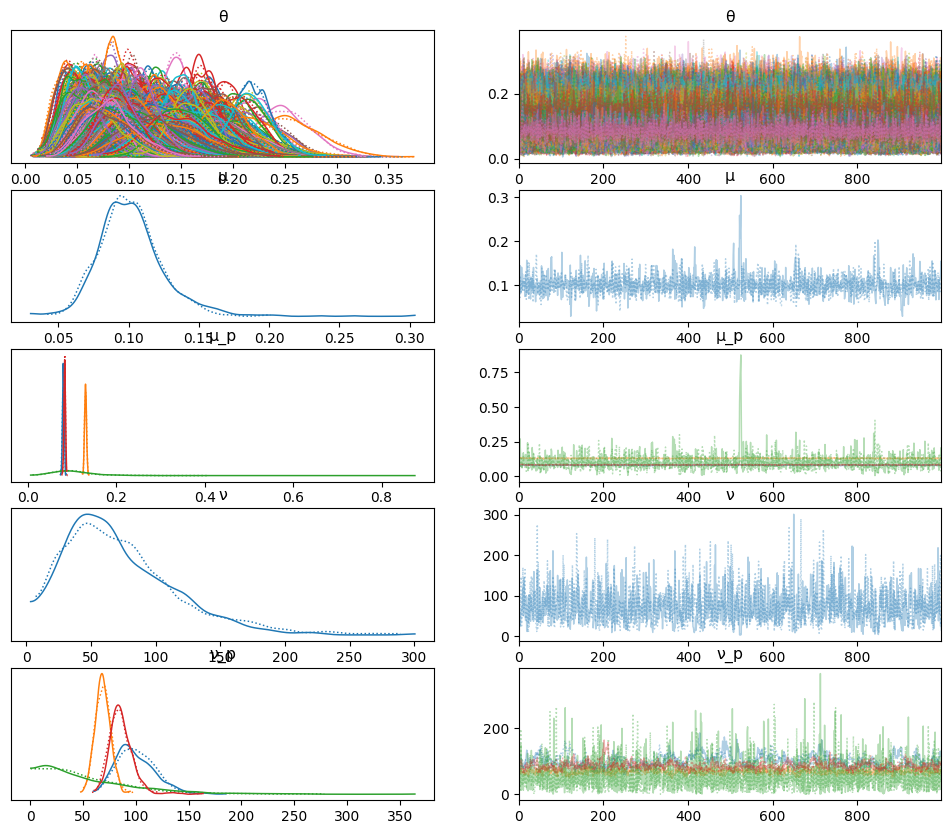

In [ ]:
az.plot_trace(h_idata_sccr)

In [15]:
az.rhat(h_idata_sccr)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 1.005 0.9992 1.0 ... 1.001 1.0 0.9998
    μ        float64 8B 0.9995
    μ_p      (pos) float64 32B 1.006 1.0 1.001 0.9997
    ν        float64 8B 1.001
    ν_p      (pos) float64 32B 1.016 1.001 1.001 1.004

The hierarchical model without goalkeepers was easier for pymc to process. When we drop GKs from the data, we lose the model's ability to predict their shooting percentage, but since the model isn't very good at that anyway, we don't lose much. We also have a lower rhat for DF, so the hierarchical model is more confident there. We also gain a faster run time.